# Spec2Vec - Find similar compounds for unknown substances
One very important use case for a spectral similariy measure is libarary matching.  
This means matching previously unseen/unknown spectra to known, annotated sepctra in a larger library.

In [1]:
import os
import sys
import gensim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

ROOT = os.path.dirname(os.getcwd())
#path_data = os.path.join(ROOT, 'data')
path_data = 'C:\\Users\\joris\\Documents\\eScience_data\\data'
sys.path.insert(0, ROOT)
sys.path.insert(0, "C:\\Users\\joris\\Documents\\eScience_data\\spec2vec_gnps_data_analysis\\custom_functions")

### Import pre-processed dataset "AllPositive"

In [4]:
from matchms.importing import load_from_json

filename = os.path.join(path_data,'gnps_positive_ionmode_cleaned_by_matchms_and_lookups.json')
spectrums = load_from_json(filename)

print("number of spectra:", len(spectrums))

number of spectra: 112956


In [5]:
spectrums[0].metadata

{'spectrum_id': 'CCMSLIB00000001547',
 'source_file': '130618_Ger_Jenia_WT-3-Des-MCLR_MH981.4-qb.1.1..mgf',
 'task': '47daa4396adb426eaa5fa54b6ce7dd5f',
 'scan': '-1',
 'ms_level': '2',
 'library_membership': 'GNPS-LIBRARY',
 'spectrum_status': '1',
 'splash': 'splash10-0w2a-0001282259-0001282259',
 'submit_user': 'mwang87',
 'compound_name': '3-Des-Microcystein_LR',
 'ion_source': 'LC-ESI',
 'compound_source': 'Isolated',
 'instrument': 'qTof',
 'pi': 'Gerwick',
 'data_collector': 'Jenia',
 'adduct': 'M+H',
 'precursor_mz': 981.54,
 'exactmass': '0.0',
 'charge': 1,
 'cas_number': 'N/A',
 'pubmed_id': 'N/A',
 'smiles': 'CC(C)CC1NC(=O)C(C)NC(=O)C(=C)N(C)C(=O)CCC(NC(=O)C(C)C(NC(=O)C(CCCNC(N)=N)NC(=O)C(C)C(NC1=O)C(O)=O)\\C=C\\C(\\C)=C\\C(C)C(O)Cc1ccccc1)C(O)=O',
 'inchi': 'InChI=1S/C48H72N10O12/c1-25(2)22-36-45(66)57-39(47(69)70)29(6)41(62)54-34(16-13-21-51-48(49)50)44(65)53-33(18-17-26(3)23-27(4)37(59)24-32-14-11-10-12-15-32)28(5)40(61)55-35(46(67)68)19-20-38(60)58(9)31(8)43(64)52-30(7)

Text(0, 0.5, 'number of spectra in respective bin')

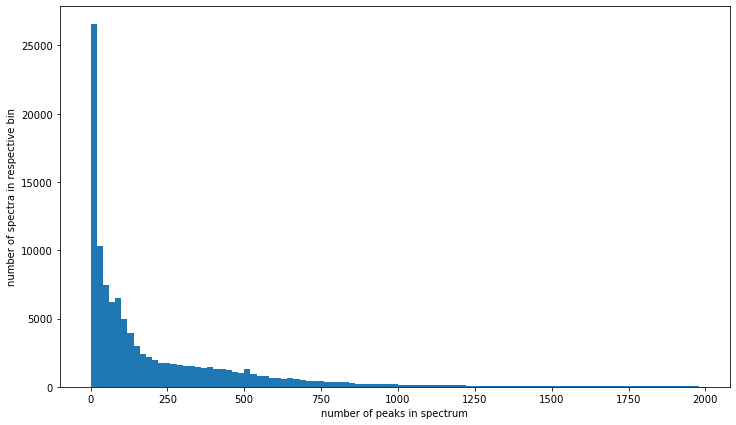

In [4]:
number_of_peaks = [len(spec.peaks) for spec in spectrums]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

## Post-process data
We here do different post-processing for either the "classical" scores (Cosine, modified Cosine) or Spe2Vec. The reason for this is mostly to make sure that we do full justice to the classical similarity measures.

#### Post-processing for classical scores
Cosine and modified cosine scores are build on multiplying intensities of matching peaks. Small peaks (<0.01) hence contribute very little to the final scores and are left out to avoid excessive computation times. 
+ normalize peaks (maximum intensity to 1)
+ remove peaks outside [0, 1000] m/z window
+ remove spectra with < 10 peaks
+ remove peaks with intensities < 0.01 of maximum intensity.

#### Post-processing for Spec2Vec
Spec2Vec similarity scores rely on creating a ``document vector`` for each spectrum. For the underlying word2vec model we want the documents (=spectra) to be more homogeneous in their number of unique words. Assuming that larger compounds will on average break down into a higher number of meaningful fragment peaks we reduce the document size of each spectrum according to its parent mass.
+ normalize peaks (maximum intensity to 1)
+ remove peaks outside [0, 1000] m/z window
+ remove spectra with < 10 peaks
+ reduce number of peaks to maximum of 0.5 * parent mass
+ remove peaks with intensities < 0.001 of maximum intensity (unless this brings number of peaks to less than 10)

In [7]:
def post_process_s2v(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    if s is None:
        return None
    s_remove_low_peaks = select_by_relative_intensity(s, intensity_from=0.001)
    if len(s_remove_low_peaks.peaks) >= 10:
        s = s_remove_low_peaks
        
    s = add_losses(s, loss_mz_from=5.0, loss_mz_to=200.0)
    return s

# apply post processing steps to the data
spectrums_s2v = [post_process_s2v(s) for s in spectrums]

# omit spectrums that didn't qualify for analysis
spectrums_s2v = [s for s in spectrums_s2v if s is not None]

print("{} remaining spectra.".format(len(spectrums_s2v)))

95320 remaining spectra.


Text(0, 0.5, 'number of spectra in respective bin')

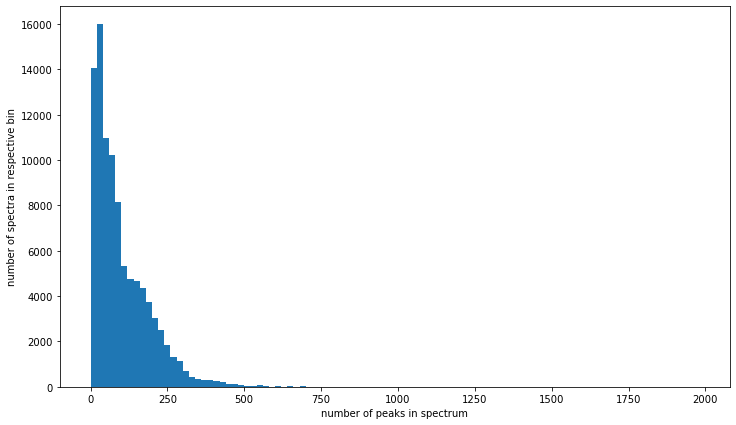

In [9]:
number_of_peaks = [len(spec.peaks) for spec in spectrums_s2v]

plt.figure(figsize=(12,7))
hist = plt.hist(number_of_peaks, np.arange(0,2000,20))
plt.xlabel("number of peaks in spectrum")
plt.ylabel("number of spectra in respective bin")

In [10]:
np.max(number_of_peaks)

1081

## Inspect annotations

In [8]:
Inchikeys = []
for spec in spectrums_s2v:
    Inchikeys.append(spec.get("inchikey"))

In [12]:
Inchikeys[:10]

['IYDKWWDUBYWQGF-NNAZGLEUSA-N',
 'KNGPFNUOXXLKCN-ZNCJFREWSA-N',
 'WXDBUBIFYCCNLE-NSCMQRKRSA-N',
 'CGZKSPLDUIRCIO-RPCRKUJJSA-N',
 '',
 'USXIYWCPCGVOKF-LERJCCFDSA-N',
 '',
 'WCNJVJCYRBJSLC-BCJYPDSRSA-N',
 'USXIYWCPCGVOKF-NOENWEJRSA-N',
 'WCNJVJCYRBJSLC-BCJYPDSRSA-N']

In [10]:
inchikeys_pd = pd.Series([x for x in Inchikeys if x])
inchikeys_pd.str[:14].value_counts()[:30]

NEGQHKSYEYVFTD    432
SULIDBRAXVDKBU    426
IQGPMZRCLCCXAG    308
WTJKGGKOPKCXLL    295
IIZPXYDJLKNOIY    235
RWKUXQNLWDTSLO    234
QIBZFHLFHCIUOT    225
ZAYXPDDGEIJGGW    212
QJWDAOSZZYVBJZ    210
KILNVBDSWZSGLL    205
RFVFQQWKPSOBED    202
IESVDEZGAHUQJU    197
LFUDDCMNKWEORN    195
JLPULHDHAOZNQI    182
LSOWKZULVQWMLY    180
XGGMHQYOVYWRLV    178
LLHISNQVRRYJGL    175
JFISYPWOVQNHLS    174
SRIGHEHXEGELQJ    166
ACTIUHUUMQJHFO    163
PZNPLUBHRSSFHT    162
YLWSJLLZUHSIEA    158
GPWHCUUIQMGELX    150
BLZVZPYMHLXLHG    148
QEDPUVGSSDPBMD    146
IGZPHNNYPPAPLA    142
CITHEXJVPOWHKC    141
YEJYLHKQOBOSCP    131
SXNXGNVZTLZDHE    131
AXZGUCXCTZMPTR    128
dtype: int64

Text(0, 0.5, 'Number of inchikeys with respective number of occurences')

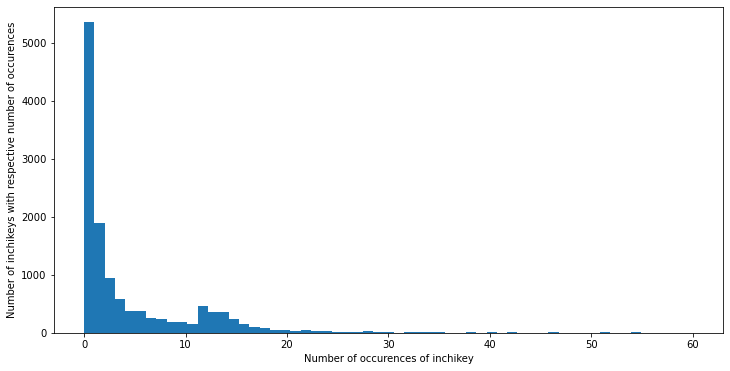

In [14]:
plt.figure(figsize=(12,6))
plt.hist(inchikeys_pd.str[:14].value_counts(), np.linspace(0, 60, 60))
plt.xlabel('Number of occurences of inchikey')
plt.ylabel('Number of inchikeys with respective number of occurences')

In [11]:
suitable_inchikeys = pd.DataFrame(inchikeys_pd.str[:14].value_counts()[inchikeys_pd.str[:14].value_counts().values >= 5])
suitable_inchikeys.reset_index(level=suitable_inchikeys.index.names, inplace=True)
suitable_inchikeys.columns = (['inchikey14', 'occurences'])

# Important: sort values to make it reproducible (same occurences have random order otherwise!)
suitable_inchikeys = suitable_inchikeys.sort_values(['occurences', 'inchikey14'], ascending=False)
suitable_inchikeys.head(15)

,inchikey14,occurences
0,NEGQHKSYEYVFTD,432
1,SULIDBRAXVDKBU,426
2,IQGPMZRCLCCXAG,308
3,WTJKGGKOPKCXLL,295
4,IIZPXYDJLKNOIY,235
5,RWKUXQNLWDTSLO,234
6,QIBZFHLFHCIUOT,225
7,ZAYXPDDGEIJGGW,212
8,QJWDAOSZZYVBJZ,210
9,KILNVBDSWZSGLL,205


In [16]:
print("Number of spectra with inchikeys that exist >= 5 times:", suitable_inchikeys.shape[0])

Number of spectra with inchikeys that exist >= 5 times: 4079


### Randomly select 1000 inchikeys that exist >=5  times in the dataset

In [12]:
num_spectra = 1000

np.random.seed(42) # to make it reproducible
selection = np.random.choice(suitable_inchikeys.shape[0], num_spectra, replace=False)
print(selection[:25])
selected_inchikeys = suitable_inchikeys['inchikey14'].values[selection]
selected_inchikeys[:25]

[  33 3233 1556 2547  457 3598  857 1878  705  803 1642  495 2866 1034
 1517  564 2826  568 2575 3956  670 3317 1498 2971   96]


array(['SRRQPVVYXBTRQK', 'JUZYLCPPVHEVSV', 'UZXMLGUMBQQVME',
       'PDAKXMIQFUHWQC', 'JFVKWCYZKMUTLH', 'HQPCSDADVLFHHO',
       'HUPGTAGQEXENPN', 'YPKUMLKVFXFYOT', 'KWIUHFFTVRNATP',
       'QJVXKWHHAMZTBY', 'PGERTGWKXFAEFR', 'MIHLTJZHRJACQQ',
       'YFAGHNZHGGCZAX', 'LKWWJGGLULNRBP', 'XWTYSIMOBUGWOL',
       'BPEXJHGGARTCIR', 'FHHVIBPVBBRLOR', 'YFPYXTNSQOUHPS',
       'LTLYEAJONXGNFG', 'INOGLHRUEYDAHX', 'VGOJYSUPEJWUNN',
       'BPICBUSOMSTKRF', 'ZQHJXKYYELWEOK', 'MXHRCPNRJAMMIM',
       'QXMHHXQBBKDSSL'], dtype=object)

In [18]:
num_spectra = 1000

np.random.seed(42) # to make it reproducible
selection = np.random.choice(suitable_inchikeys.shape[0], num_spectra, replace=False)
print(selection[:25])
selected_inchikeys = suitable_inchikeys['inchikey14'].values[selection]
selected_inchikeys[:25]

[  33 3233 1556 2547  457 3598  857 1878  705  803 1642  495 2866 1034
 1517  564 2826  568 2575 3956  670 3317 1498 2971   96]


array(['SRRQPVVYXBTRQK', 'JUZYLCPPVHEVSV', 'UZXMLGUMBQQVME',
       'PDAKXMIQFUHWQC', 'JFVKWCYZKMUTLH', 'HQPCSDADVLFHHO',
       'HUPGTAGQEXENPN', 'YPKUMLKVFXFYOT', 'KWIUHFFTVRNATP',
       'QJVXKWHHAMZTBY', 'PGERTGWKXFAEFR', 'MIHLTJZHRJACQQ',
       'YFAGHNZHGGCZAX', 'LKWWJGGLULNRBP', 'XWTYSIMOBUGWOL',
       'BPEXJHGGARTCIR', 'FHHVIBPVBBRLOR', 'YFPYXTNSQOUHPS',
       'LTLYEAJONXGNFG', 'INOGLHRUEYDAHX', 'VGOJYSUPEJWUNN',
       'BPICBUSOMSTKRF', 'ZQHJXKYYELWEOK', 'MXHRCPNRJAMMIM',
       'QXMHHXQBBKDSSL'], dtype=object)

### Randomly pick one spectra for each of the chosen inchikeys

In [13]:
selected_spectra = []
inchikeys_pd = pd.Series([x for x in Inchikeys]) #include all even empty ones to get the IDs right!

np.random.seed(42) # to make it reproducible
for inchikey in selected_inchikeys:
    matches = inchikeys_pd[inchikeys_pd.str[:14] == inchikey].index.values
    selected_spectra.append(int(np.random.choice(matches,1)[0]))

In [20]:
selected_spectra[:10]

[52728, 6129, 78135, 62556, 73314, 21762, 12492, 88980, 63188, 74380]

In [21]:
selected_spectra[:10]

[52728, 6129, 78135, 62556, 73314, 21762, 12492, 88980, 63188, 74380]

In [14]:
# Show gnps IDs for selected spectra
for ID in selected_spectra[:10]:
    print(spectrums_s2v[ID].get("spectrumid"),
         spectrums_s2v[ID].get("inchikey")[:14])

CCMSLIB00003128874 SRRQPVVYXBTRQK
CCMSLIB00000005841 JUZYLCPPVHEVSV
CCMSLIB00004701389 UZXMLGUMBQQVME
CCMSLIB00000215466 PDAKXMIQFUHWQC
CCMSLIB00004695353 JFVKWCYZKMUTLH
CCMSLIB00003136589 HQPCSDADVLFHHO
CCMSLIB00000850213 HUPGTAGQEXENPN
CCMSLIB00004715739 YPKUMLKVFXFYOT
CCMSLIB00000217500 KWIUHFFTVRNATP
CCMSLIB00004696689 QJVXKWHHAMZTBY


## Train new model on AllPositive dataset WITHOUT selected spectra

In [15]:
from spec2vec import Spec2VecParallel
from spec2vec import SpectrumDocument

In [16]:
documents_library_s2v = [SpectrumDocument(s, n_decimals=2) for ind, s in enumerate(spectrums_s2v) if ind not in selected_spectra]
documents_library_classical = [SpectrumDocument(s, n_decimals=2) for ind, s in enumerate(spectrums_classical) if ind not in selected_spectra]

In [25]:
len(documents_library_s2v), len(spectrums_s2v)  # 1000 should be removed

(94320, 95320)

In [26]:
#from spec2vec.model_building import train_new_word2vec_model

#path_models = os.path.join(path_data, "trained_models")
#model_file = os.path.join(path_models, "spec2vec_librarymatching.model")

#iterations = [1, 3, 5, 10, 15, 20]

# Train model with default parameters
#model = train_new_word2vec_model(documents_library_s2v, iterations, model_file)

## Actual library matching

In [17]:
sys.path.insert(0, "C:\\Users\\joris\\Documents\\eScience_data\\spec2vec_gnps_data_analysis\\custom_functions")

In [18]:
from library_search import library_matching

#### Load word2vec model

In [29]:
path_models = os.path.join(path_data, "trained_models")
model_file = os.path.join(path_models, "spec2vec_librarymatching_iter_15.model")
model = gensim.models.Word2Vec.load(model_file)

In [38]:
print(model)


Word2Vec(vocab=115910, size=300, alpha=0.025)


In [19]:
documents_query_s2v = [SpectrumDocument(spectrums_s2v[i], n_decimals=2) for i in selected_spectra]

In [32]:
len(documents_query_s2v)

1000

In [33]:
documents_query_s2v[0]._obj.get("inchikey")

'SRRQPVVYXBTRQK-XMMPIXPASA-N'

### Correct a few (< 10) spectrums with missing precursor_mz (in place)

In [20]:
for i, spec in enumerate(spectrums_s2v):
    if not spec.get("precursor_mz"):
        print(i)
        fix_mass = 0.0
        for history in spec.metadata['annotation_history']:
            fix_mass_test = float(history['Precursor_MZ'])
            fix_mass = max(fix_mass, fix_mass_test)
        charge = spec.get("charge")
        protons_mass = 1.00727645199076 * charge
        precursor_mass = fix_mass * abs(charge)
        parent_mass = precursor_mass - protons_mass
        if parent_mass:
            print("parent mass new:", parent_mass, "former was:", spec.get("parent_mass"))
            spec.set("parent_mass", parent_mass)
        print("precursor_mz new:", fix_mass, "former was:", spec.get("precursor_mz"))
        spec.set("precursor_mz", fix_mass)

2765
parent mass new: 547.2247235480093 former was: -1.00727645199076
precursor_mz new: 548.232 former was: 0.0
2766
parent mass new: 589.2357235480093 former was: -1.00727645199076
precursor_mz new: 590.243 former was: 0.0
3942
parent mass new: 466.2697235480092 former was: -1.00727645199076
precursor_mz new: 467.277 former was: 0.0
3974
parent mass new: 674.4887235480093 former was: -1.00727645199076
precursor_mz new: 675.496 former was: 0.0
3975
parent mass new: 691.5147235480093 former was: -1.00727645199076
precursor_mz new: 692.522 former was: 0.0
3976
parent mass new: 696.4707235480092 former was: -1.00727645199076
precursor_mz new: 697.478 former was: 0.0
3983
parent mass new: 629.6107235480093 former was: -1.00727645199076
precursor_mz new: 630.618 former was: 0.0
3984
parent mass new: 491.47072354800923 former was: -1.00727645199076
precursor_mz new: 492.478 former was: 0.0
3985
parent mass new: 531.4627235480093 former was: -1.00727645199076
precursor_mz new: 532.47 former w

### Run Spec2Vec and parentmass based library matching for 1000 against 94320 spectra

In [36]:
found_matches_s2v = library_matching(documents_query_s2v, documents_library_s2v,
                                     model,
                                     presearch_based_on=["parentmass", "spec2vec-top20"],
                                     ignore_non_annotated=True,
                                     intensity_weighting_power=0.5,
                                     allowed_missing_percentage=5.0,
                                     cosine_tol=0.005,
                                     mass_tolerance=1.0)

Pre-selection includes spec2vec top 20.


In [21]:
import pickle
outfile = os.path.join(path_data, 'found_matches_s2v.pickle')
print(outfile)
if os.path.exists(outfile):
    with open(outfile, 'rb') as inf:
        found_matches_s2v = pickle.load(inf)
else:
    with open(outfile, 'wb') as outf:
        pickle.dump(found_matches_s2v, outf)

C:\Users\joris\Documents\eScience_data\data\found_matches_s2v.pickle


In [22]:
print(len(found_matches_s2v))

1000


In [53]:
print(type(found_matches_s2v))

<class 'list'>


In [3]:
ID = 0
found_matches_s2v[ID].sort_values(by=["s2v_score"], ascending=False)

,cosine_score,cosine_matches,mod_cosine_score,mod_cosine_matches,mass_match,s2v_score
46003,0.960780,3,0.960780,3,1.0,0.887800
38195,0.049197,1,0.971344,3,0.0,0.858902
48062,0.043040,2,0.043040,2,0.0,0.848561
45969,0.049498,1,0.961919,2,0.0,0.844523
32755,0.119678,1,0.608107,2,0.0,0.811812
...,...,...,...,...,...,...
78615,0.000000,0,0.000000,0,1.0,-0.085632
1556,0.000000,0,0.000000,0,1.0,-0.088960
12317,0.000000,0,0.000000,0,1.0,-0.092868
74298,0.000000,0,0.000000,0,1.0,-0.099162


In [ ]:
found_matches_classical[0].sort_values(by=["cosine_score"], ascending=False)

In [67]:
threshold = 0.5
min_match = 1
df_select = found_matches_s2v[ID][(found_matches_s2v[ID]['mass_match'] == 1)
                     & (found_matches_s2v[ID]['cosine_score'] > threshold)
                     & (found_matches_s2v[ID]['cosine_matches'] >= min_match)]
best_match_ID = df_select.sort_values(by=['cosine_score'], ascending=False).index[0]
print(best_match_ID)
print(documents_library_s2v[best_match_ID]._obj.get("inchikey"))
print(documents_query_s2v[ID]._obj.get("inchikey"))

72679
JFVKWCYZKMUTLH-GRWTVWFQSA-N
JFVKWCYZKMUTLH-GRWTVWFQSA-N


46003

In [68]:
test_matches_s2v = []

cosine_thresholds = np.arange(0,1,0.05)

for threshold in cosine_thresholds:
    print("Checking matches for S2V score >", threshold)
    test_matches = []
    
    for ID in range(len(documents_query_s2v)):

        # Scenario 2: mass + sort by Spec2Vec
        df_select = found_matches_s2v[ID][(found_matches_s2v[ID]['mass_match'] == 1)
                                      & (found_matches_s2v[ID]['s2v_score'] > threshold)]
        if df_select.shape[0] > 0:
            best_match_ID = df_select.sort_values(by=['s2v_score'], ascending=False).index[0]
            inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
            inchikey_query = documents_query_s2v[ID]._obj.get("inchikey")[:14]
            
            best_bet = 1 * (inchikey_selected == inchikey_query)
        else:
            best_bet = -1 # meaning: not found
        test_matches.append(best_bet)

    # Make arrays from lists:
    test_arr = np.array(test_matches)
    
    test_matches_s2v.append([np.sum(test_arr == 1), np.sum(test_arr == 0), np.sum(test_arr == -1)])

Checking matches for S2V score > 0.0
Checking matches for S2V score > 0.05
Checking matches for S2V score > 0.1
Checking matches for S2V score > 0.15000000000000002
Checking matches for S2V score > 0.2
Checking matches for S2V score > 0.25
Checking matches for S2V score > 0.30000000000000004
Checking matches for S2V score > 0.35000000000000003
Checking matches for S2V score > 0.4
Checking matches for S2V score > 0.45
Checking matches for S2V score > 0.5
Checking matches for S2V score > 0.55
Checking matches for S2V score > 0.6000000000000001
Checking matches for S2V score > 0.65
Checking matches for S2V score > 0.7000000000000001
Checking matches for S2V score > 0.75
Checking matches for S2V score > 0.8
Checking matches for S2V score > 0.8500000000000001
Checking matches for S2V score > 0.9
Checking matches for S2V score > 0.9500000000000001


Text(0, 0.5, 'true positives')

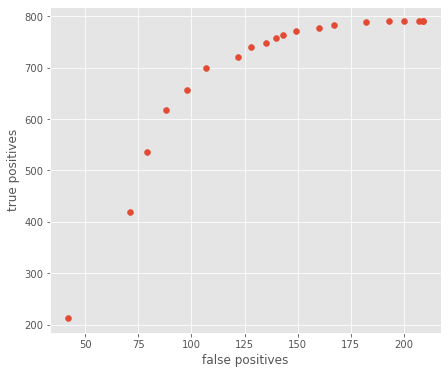

In [78]:
test_matches_s2v_arr = np.array(test_matches_s2v)

plt.figure(figsize=(7,6))
plt.style.use('ggplot')
plt.scatter(test_matches_s2v_arr[:,1], test_matches_s2v_arr[:,0])
plt.xlabel('false positives')
plt.ylabel('true positives')

In [76]:
np.array(test_matches_s2v)[:,:]

array([[790, 209,   1],
       [790, 209,   1],
       [790, 207,   3],
       [790, 200,  10],
       [790, 193,  17],
       [789, 182,  29],
       [784, 167,  49],
       [778, 160,  62],
       [772, 149,  79],
       [764, 143,  93],
       [757, 140, 103],
       [748, 135, 117],
       [740, 128, 132],
       [721, 122, 157],
       [699, 107, 194],
       [657,  98, 245],
       [618,  88, 294],
       [536,  79, 385],
       [419,  71, 510],
       [213,  42, 745]])

In [175]:
#Trying to find a label of true or false positive for each query at a certain s2v score threshold
true_pos_s2v = []
false_pos_s2v = []
#df ends up as rows: query document number, cols: features (from found_matches) and true or false positive
best_matches_labeled_s2v = pd.DataFrame()

threshold = 0.4
print("Checking matches for S2V score >", threshold)

for ID in range(len(documents_query_s2v)):
    # Scenario 2: mass + sort by Spec2Vec
    df_select = found_matches_s2v[ID][(found_matches_s2v[ID]['mass_match'] == 1)
                                  & (found_matches_s2v[ID]['s2v_score'] > threshold)]
    if df_select.shape[0] > 0:
        best_match = df_select.sort_values(by=['s2v_score'], ascending=False).iloc[0]
        best_match_ID = best_match.name
        inchikey_selected = documents_library_s2v[best_match_ID]._obj.get("inchikey")[:14]
        inchikey_query = documents_query_s2v[ID]._obj.get("inchikey")[:14]

        best_bet = 1 * (inchikey_selected == inchikey_query)
        
        best_match['label'] = best_bet
        best_match.rename(ID, inplace=True)
        best_matches_labeled_s2v = best_matches_labeled_s2v.append(best_match)
    else:
        best_bet = -1 # meaning: not found - not interesting in this case

    #record pairs
    if best_bet == 1:
        true_pos_s2v.append((ID, best_match_ID))
    elif best_bet == 0:
        false_pos_s2v.append((ID, best_match_ID)) #record best hit for false positive

Checking matches for S2V score > 0.4


In [176]:
print(len(true_pos_s2v), len(false_pos_s2v))
print(true_pos_s2v[0])
print(best_matches_labeled_s2v[best_matches_labeled_s2v['label']==0].iloc[0:10])

772 149
(0, 46003)
    cosine_matches  cosine_score  label  mass_match  mod_cosine_matches  \
8              4.0      0.474605    0.0         1.0                 4.0   
16             0.0      0.000000    0.0         1.0                 0.0   
18             7.0      0.000094    0.0         1.0                10.0   
22           134.0      0.717124    0.0         1.0               134.0   
46             9.0      0.987546    0.0         1.0                 9.0   
48            65.0      0.016529    0.0         1.0                72.0   
52            65.0      0.999897    0.0         1.0                65.0   
65           141.0      0.663807    0.0         1.0               140.0   
66            51.0      0.997571    0.0         1.0                51.0   
74             2.0      0.504692    0.0         1.0                 2.0   

    mod_cosine_score  s2v_score  
8           0.474605   0.480207  
16          0.000000   0.949601  
18          0.000190   0.478899  
22          0.71712

In [177]:
#store labels
labels = np.array(best_matches_labeled_s2v['label'])
#remove labels
best_matches_s2v = best_matches_labeled_s2v.drop('label', axis = 1)
feature_list = list(best_matches_s2v.columns)
best_matches_s2v = np.array(best_matches_s2v)

In [178]:
from sklearn.model_selection import train_test_split
#make training and testing sets
train_features, test_features,\
train_labels, test_labels = train_test_split(best_matches_s2v, labels,
                                             test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (690, 6)
Training Labels Shape: (690,)
Testing Features Shape: (231, 6)
Testing Labels Shape: (231,)


In [179]:
print(test_labels)
print("False positive rate test set: ", 1 - (np.sum(test_labels)/len(test_labels)))

[0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1.]
False positive rate test set:  0.16450216450216448


In [180]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(train_features, train_labels)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [181]:
predictions = rf.predict(test_features)
print(predictions)
accuracy = sum(1 for test, pred in zip(test_labels, predictions) if test == pred) / len(test_labels)
print("Accuracy:", accuracy)
print("False positive rate predictions: ", 1 - (np.sum(predictions)/len(predictions)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Accuracy: 0.8311688311688312
False positive rate predictions:  0.030303030303030276


In [182]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: s2v_score            Importance: 0.25
Variable: cosine_score         Importance: 0.21
Variable: mod_cosine_score     Importance: 0.2
Variable: cosine_matches       Importance: 0.17
Variable: mod_cosine_matches   Importance: 0.17
Variable: mass_match           Importance: 0.0


In [183]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def do_random_forest(feature_df, label_name, verbose = True):
    '''Split data in training and test, train rf, predict on test

    feature_df: pandas DataFrame
    label_name: str, name of the label column in feature_df
    verbose: bool, print more info
    '''
    #store labels
    labels = np.array(feature_df[label_name])
    #remove labels
    feature_df_nolab = feature_df.drop(label_name, axis = 1)
    feature_list = list(feature_df_nolab.columns)
    feature_df_nolab = np.array(feature_df_nolab)
    
    #split data in training and test set
    train_features, test_features,\
    train_labels, test_labels = train_test_split(feature_df_nolab, labels,
                                                 test_size = 0.25, random_state = 42)
    if verbose:
        print('Training Features Shape:', train_features.shape)
        print('Training Labels Shape:', train_labels.shape)
        print('Testing Features Shape:', test_features.shape)
        print('Testing Labels Shape:', test_labels.shape)
        print(test_labels)
    print("Percentage false positives test set: ", 1 - (np.sum(test_labels)/len(test_labels)))
    
    #train model
    rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
    rf.fit(train_features, train_labels)
    
    #predict test set
    predictions = rf.predict(test_features)
    if verbose:
        print(predictions)
    accuracy = sum(1 for test, pred in zip(test_labels, predictions) if test == pred) / len(test_labels)
    print("Accuracy:", accuracy)
    print("Predicted percentage false positives test set: ", 1 - (np.sum(predictions)/len(predictions)))

    #get feature importances
    importances = list(rf.feature_importances_)
    #list of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [184]:
#make ratio false to true positives 50/50
false_p = best_matches_labeled_s2v[best_matches_labeled_s2v['label']==0]
num_false_p = len(false_p)
np.random.seed(42) # to make it reproducible
chosen_true_p_inds = np.random.choice(best_matches_labeled_s2v[best_matches_labeled_s2v['label']==1].index.values, num_false_p)
best_matches_s2v_5050 = false_p.append(best_matches_labeled_s2v.loc[chosen_true_p_inds])
best_matches_s2v_5050.shape
do_random_forest(best_matches_s2v_5050, 'label')

Training Features Shape: (223, 6)
Training Labels Shape: (223,)
Testing Features Shape: (75, 6)
Testing Labels Shape: (75,)
[1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1.
 1. 1. 1.]
Percentage false positives test set:  0.5333333333333333
[0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0.
 0. 1. 0.]
Accuracy: 0.5733333333333334
Predicted percentage false positives test set:  0.5866666666666667
Variable: s2v_score            Importance: 0.25
Variable: cosine_matches       Importance: 0.19
Variable: cosine_score         Importance: 0.19
Variable: mod_cosine_matches   Importance: 0.19
Variable: mod_cosine_score     Importance: 0.19
Variable: mass_match   